clean up code

modify the optimiser to work

tune hyperparameters

visualise each stage

use torch features throughout code

use more problem types, or do a comparison with a different type of optimisation e.g. ant colony

Actually what im thinking now is to make a neural network which is trained on the data and solutions, or trained based on past runs of the PSO, then train it to predict which hyperparameter values to use.

https://www.geeksforgeeks.org/particle-swarm-optimization-pso-an-overview/  
https://github.com/mastqe/tsplib  
https://github.com/marcoscastro/tsp_pso/blob/master/references/paper.pdf  
https://www.codeproject.com/Articles/1182794/Solving-the-Travelling-Salesman-Problem-with-a-Par  
https://ieeexplore.ieee.org/document/1259748

In [2]:
import requests
import matplotlib.pyplot as plt
import torch
import matplotlib.animation as animation
from IPython.display import display

In [3]:
response = requests.get("https://raw.githubusercontent.com/mastqe/tsplib/refs/heads/master/att48.tsp")
#print(response.text)

In [4]:
class TspParser:
    name: str
    dimension: int
    nodeCoordinates: dict
    coordinatesTensor: list

    def __init__(self, fileContent):
        self.nodeCoordinates = {}
        unprocessedData = fileContent.split("\n")
        isCoordinateSection = False
        for line in unprocessedData:
            line = line.strip()

            if "EOF" in line:
                break
            if "NAME" in line:
                nameData = line.split(":")
                self.name = nameData[1] if len(nameData) == 2 else None
            if "DIMENSION" in line:
                dimensionData = line.split(":")
                self.dimension = int(dimensionData[1]) if len(dimensionData) == 2 else None
                
            if isCoordinateSection:
                line = line.strip()
                stringData = line.split()
                nodeId = int(stringData[0])
                x = float(stringData[1])
                y = float(stringData[2])
                self.nodeCoordinates[nodeId] = (x, y)
                
            if "NODE_COORD_SECTION" in line:
                isCoordinateSection = True

        self.coordinatesTensor = torch.tensor(list(self.nodeCoordinates.values()), dtype=torch.float32)

att48 = TspParser(response.text)
print(att48.name, att48.dimension, att48.nodeCoordinates)
print(att48.coordinatesTensor)

 att48 48 {1: (6734.0, 1453.0), 2: (2233.0, 10.0), 3: (5530.0, 1424.0), 4: (401.0, 841.0), 5: (3082.0, 1644.0), 6: (7608.0, 4458.0), 7: (7573.0, 3716.0), 8: (7265.0, 1268.0), 9: (6898.0, 1885.0), 10: (1112.0, 2049.0), 11: (5468.0, 2606.0), 12: (5989.0, 2873.0), 13: (4706.0, 2674.0), 14: (4612.0, 2035.0), 15: (6347.0, 2683.0), 16: (6107.0, 669.0), 17: (7611.0, 5184.0), 18: (7462.0, 3590.0), 19: (7732.0, 4723.0), 20: (5900.0, 3561.0), 21: (4483.0, 3369.0), 22: (6101.0, 1110.0), 23: (5199.0, 2182.0), 24: (1633.0, 2809.0), 25: (4307.0, 2322.0), 26: (675.0, 1006.0), 27: (7555.0, 4819.0), 28: (7541.0, 3981.0), 29: (3177.0, 756.0), 30: (7352.0, 4506.0), 31: (7545.0, 2801.0), 32: (3245.0, 3305.0), 33: (6426.0, 3173.0), 34: (4608.0, 1198.0), 35: (23.0, 2216.0), 36: (7248.0, 3779.0), 37: (7762.0, 4595.0), 38: (7392.0, 2244.0), 39: (3484.0, 2829.0), 40: (6271.0, 2135.0), 41: (4985.0, 140.0), 42: (1916.0, 1569.0), 43: (7280.0, 4899.0), 44: (7509.0, 3239.0), 45: (10.0, 2676.0), 46: (6807.0, 2993.0)

In [5]:
def compute_distance_matrix(coordinatesTensor):
    nodeCount = coordinatesTensor.shape[0]
    distance_matrix = torch.zeros((nodeCount + 1, nodeCount + 1))
    for i in range(1, nodeCount + 1):
        for j in range(1, nodeCount + 1):
            if i != j:
                distance_matrix[i, j] = torch.norm(coordinatesTensor[i-1] - coordinatesTensor[j-1])

    return distance_matrix
distance_matrix = compute_distance_matrix(att48.coordinatesTensor)
print(distance_matrix)

tensor([[   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
            0.0000],
        [   0.0000,    0.0000, 4726.6528,  ..., 1541.7292, 2378.5344,
         3743.0791],
        [   0.0000, 4726.6528,    0.0000,  ..., 5460.7476, 4389.0557,
         2087.2766],
        ...,
        [   0.0000, 1541.7292, 5460.7476,  ...,    0.0000, 1643.5051,
         3927.2454],
        [   0.0000, 2378.5344, 4389.0557,  ..., 1643.5051,    0.0000,
         2531.0273],
        [   0.0000, 3743.0791, 2087.2766,  ..., 3927.2454, 2531.0273,
            0.0000]])


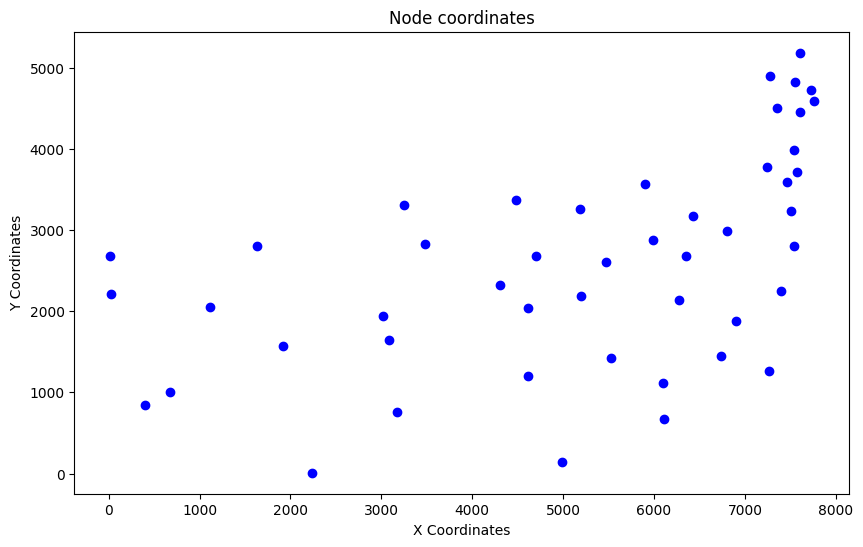

In [6]:
def plotCoordsWithoutEdges(nodeCoordinates):
    #nodeIds = list(nodeCoordinates.keys())
    xCoords = [coord[0] for coord in nodeCoordinates.values()]
    yCoords = [coord[1] for coord in nodeCoordinates.values()]
    plt.figure(figsize=(10, 6))
    plt.scatter(xCoords, yCoords, c='blue', marker='o', label='Nodes')
    plt.xlabel('X Coordinates')
    plt.ylabel('Y Coordinates')
    plt.title('Node coordinates')
    plt.show()

plotCoordsWithoutEdges(att48.nodeCoordinates)




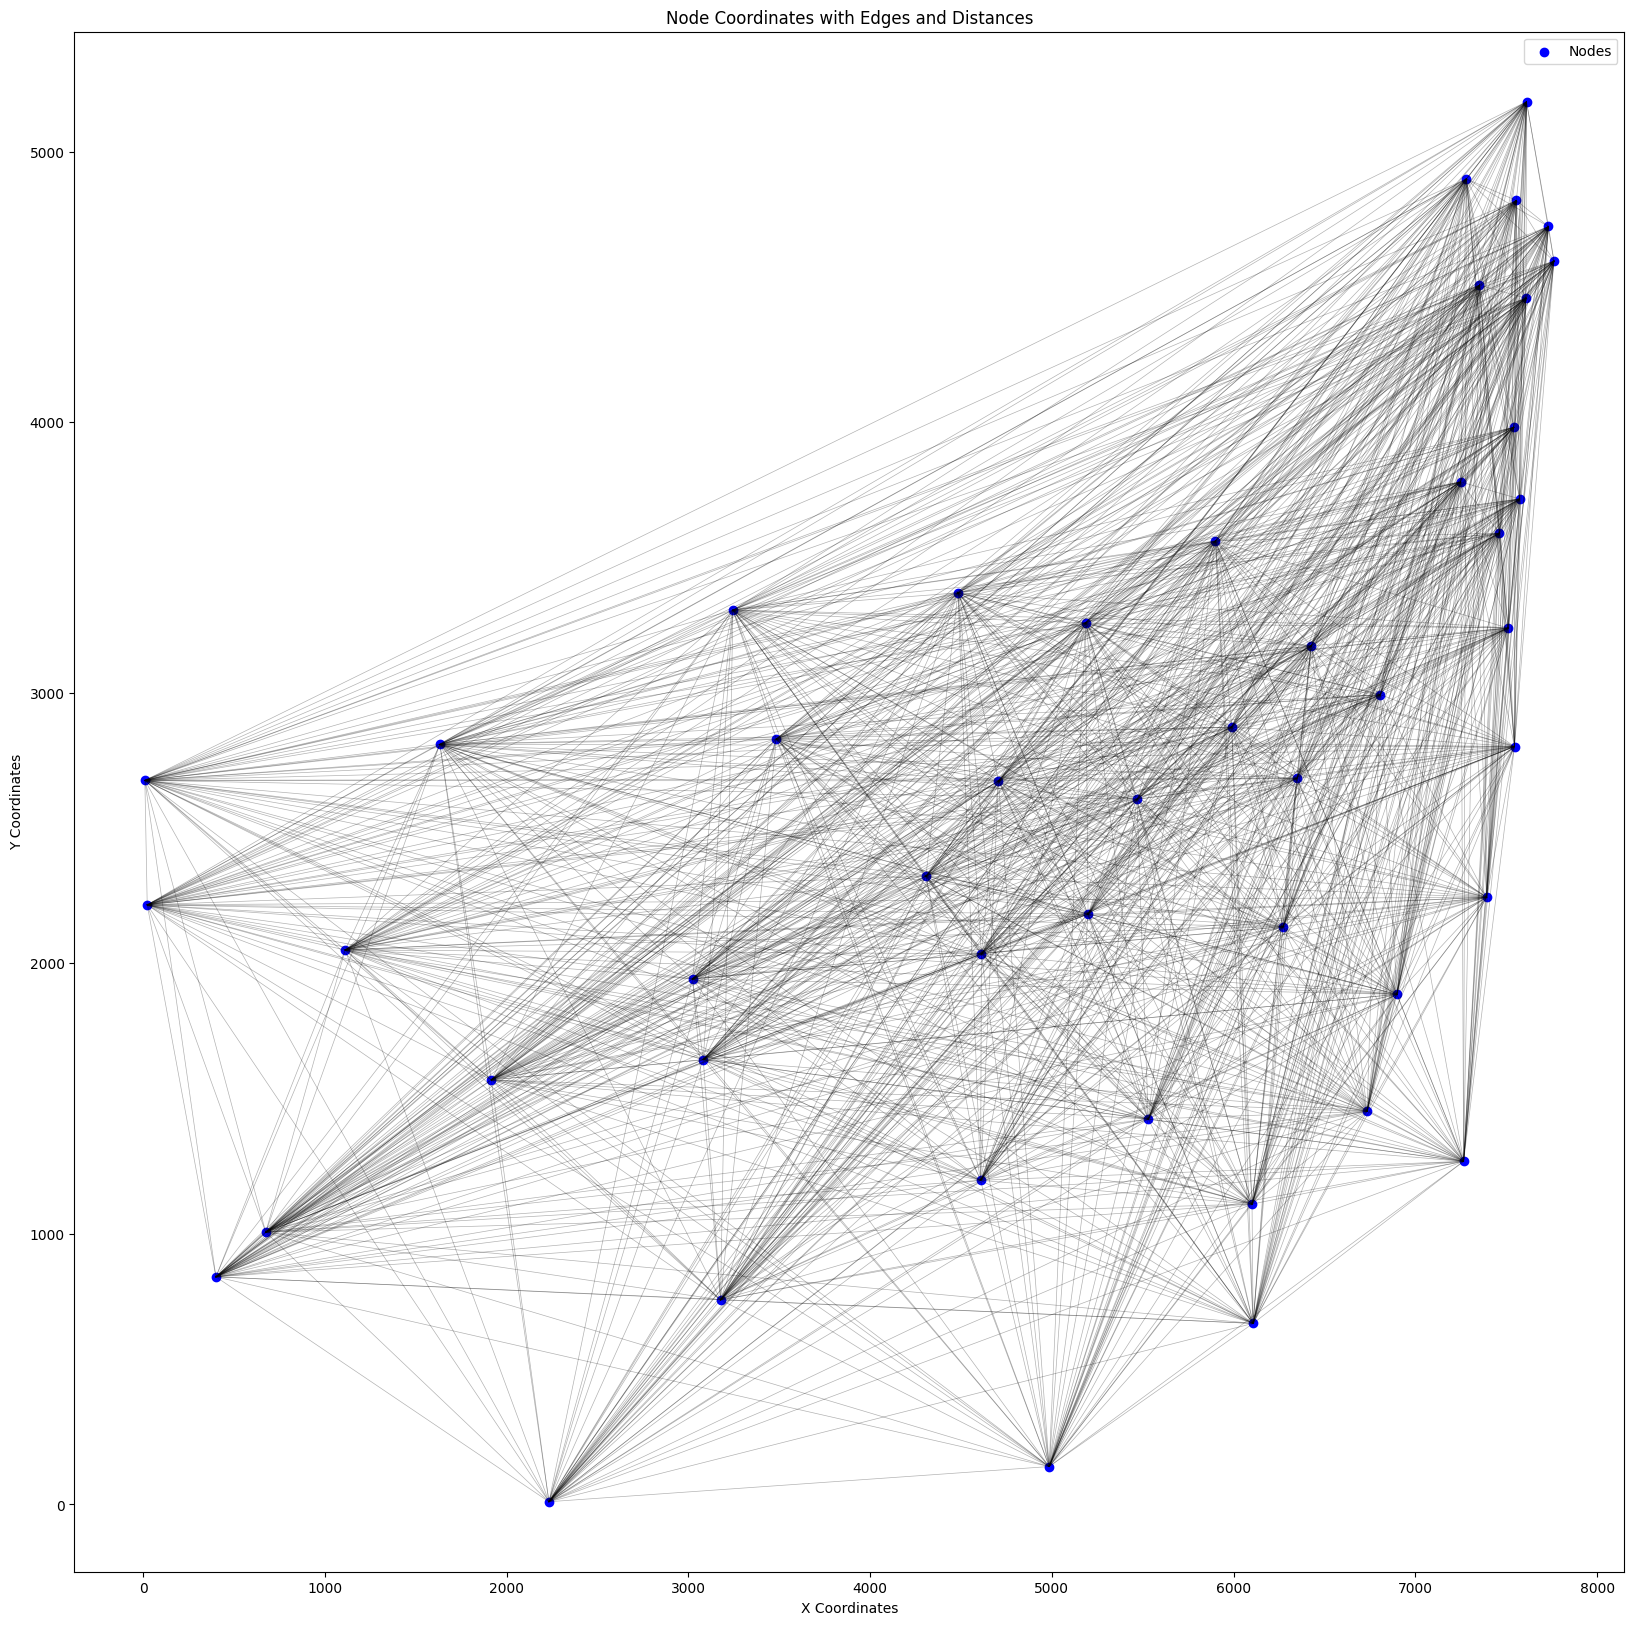

In [7]:
def plotCoordsWithEdges(nodeCoordinates, distance_matrix):
    xCoords = [coord[0] for coord in nodeCoordinates.values()]
    yCoords = [coord[1] for coord in nodeCoordinates.values()]
    plt.figure(figsize=(20, 20))
    plt.scatter(xCoords, yCoords, c='blue', marker='o', label='Nodes')

    nodeCount = len(nodeCoordinates)
    for i in range(1, nodeCount + 1): 
        for j in range(i + 1, nodeCount + 1):  # Only plot each edge once (symmetric matrix)
            if distance_matrix[i, j] > 0:  # If there's a valid distance
                x1, y1 = nodeCoordinates[i]
                x2, y2 = nodeCoordinates[j]
                
                # Plot the edge (line between nodes)
                plt.plot([x1, x2], [y1, y2], 'k-', lw=0.5, alpha=0.3)

               
    plt.xlabel('X Coordinates')
    plt.ylabel('Y Coordinates')
    plt.title('Node Coordinates with Edges and Distances')
    plt.legend()
    plt.show()


plotCoordsWithEdges(att48.nodeCoordinates, distance_matrix)

In [8]:
class Particle:
    def __init__(self, nodeCount):
        self.position = torch.randperm(nodeCount) + 1
        self.fitnessValue = float("inf")
        self.localBestFitnessPosition = self.position.clone() 
        self.localBestFitnessValue = float("inf")
        self.velocity = torch.zeros(nodeCount) + 1
        self.bestCost = float("inf")
    
    #calculate length of current route. Goes through every element in position, and uses distance matrix to get edge length
    def evaluate(self, distance_matrix):
        tour = self.position.tolist() 
        total_distance = sum(distance_matrix[tour[i], tour[i+1]] for i in range(len(tour)-1))
        total_distance += distance_matrix[tour[-1], tour[0]]
        self.fitnessValue = total_distance
        return total_distance


In [9]:


class ParticleSwarmOptimiser:
    def __init__(self, nodeCount, particleCount, inertia, particleCognition, socialInfluence, r1=1, r2=1):
        self.particleSwarm = [Particle(nodeCount) for _ in range(particleCount)]
        self.w = inertia
        self.c1 = particleCognition
        self.c2 = socialInfluence
        self.r1 = r1
        self.r2 = r2
        #self.minx = minx
        #self.maxx = maxx
        self.globalBestFitnessPosition = self.particleSwarm[0].position.clone()
        self.globalBestFitnessValue = float("inf")
        self.particleCount = particleCount
    
    def getBestSolution(self):
        return self.globalBestFitnessPosition, self.globalBestFitnessValue
    
    # def optimiseOld(self, maxIterations, distance_matrix):
    #     for _ in range(maxIterations):
    #         for i in range(self.particleCount):
    #             fitness = self.particleSwarm[i].evaluate(distance_matrix)
    #             self.particleSwarm[i].velocity = (self.w*self.particleSwarm[i].velocity +
    #                                              self.r1*self.c1*(self.particleSwarm[i].bestPos - self.particleSwarm[i].position) +
    #                                              self.r2*self.c2*( self.globalBestFitnessPosition - self.particleSwarm[i].position))
    #             self.particleSwarm[i].position += self.particleSwarm[i].velocity

    #             if self.particleSwarm[i].position < self.minx:
    #                 self.particleSwarm[i].position = self.minx
    #             elif self.particleSwarm[i].position > self.maxx:
    #                 self.particleSwarm[i].position = self.maxx
                    
    #             if self.particleSwarm[i].fitnessValue < self.particleSwarm[i].localBestFitnessValue:
    #                     self.particleSwarm[i].localBestFitnessValue = self.particleSwarm[i].fitnessValue
    #                     self.particleSwarm[i].localBestFitnessPosition = self.particleSwarm[i].position

    #             if self.particleSwarm[i].fitnessValue < self.globalBestFitnessValue:
    #                 self.globalBestFitnessValue = self.particleSwarm[i].fitnessValue
    #                 self.globalBestFitnessPosition = self.particleSwarm[i].position

    def optimise(self, distance_matrix, maxIterations):
        for iteration in range(maxIterations):
            #print(iteration)
            for particle in self.particleSwarm:
                fitness = particle.evaluate(distance_matrix)
                #print(f"particles best path: {particle.localBestFitnessPosition}")
                #print(f"particles best value: {particle.localBestFitnessValue}")
                if fitness < particle.localBestFitnessValue:
                    particle.localBestFitnessValue = fitness
                    particle.localBestFitnessPosition = particle.position.clone()

                if fitness < self.globalBestFitnessValue:
                    self.globalBestFitnessValue = fitness
                    self.globalBestFitnessPosition = particle.position.clone()

            for particle in self.particleSwarm:
                new_position = self.apply_swap_mutation(particle.position.clone(), self.globalBestFitnessPosition)
                particle.position = new_position
                        
    def refine():
        #take in new hyperparameters without necessarily modifying particle swarm
        pass

    def apply_swap_mutation(self, position, globalBest):
        swap_indices = torch.randperm(len(position))[:2]
        i, j = swap_indices[0].item(), swap_indices[1].item()
        position[i], position[j] = position[j].clone(), position[i].clone()
        return position

        

In [10]:

particle_count = 100
max_iterations = 100
inertia = 0.8
c1 = 1.5
c2 = 1.5

pso = ParticleSwarmOptimiser(
    nodeCount=att48.dimension,
    particleCount=particle_count,
    inertia=inertia,
    particleCognition=c1,
    socialInfluence=c2
)

pso.optimise(distance_matrix, max_iterations)
best_path, best_cost = pso.getBestSolution()

print("\nBest Path Found:", best_path.tolist())
print("Best Cost:", best_cost)


Best Path Found: [24, 5, 48, 47, 32, 35, 4, 3, 19, 17, 39, 12, 36, 38, 46, 44, 29, 42, 2, 34, 41, 14, 13, 1, 7, 40, 33, 25, 23, 26, 16, 22, 6, 45, 11, 18, 9, 37, 43, 27, 20, 30, 10, 28, 31, 8, 15, 21]
Best Cost: tensor(120374.4375)


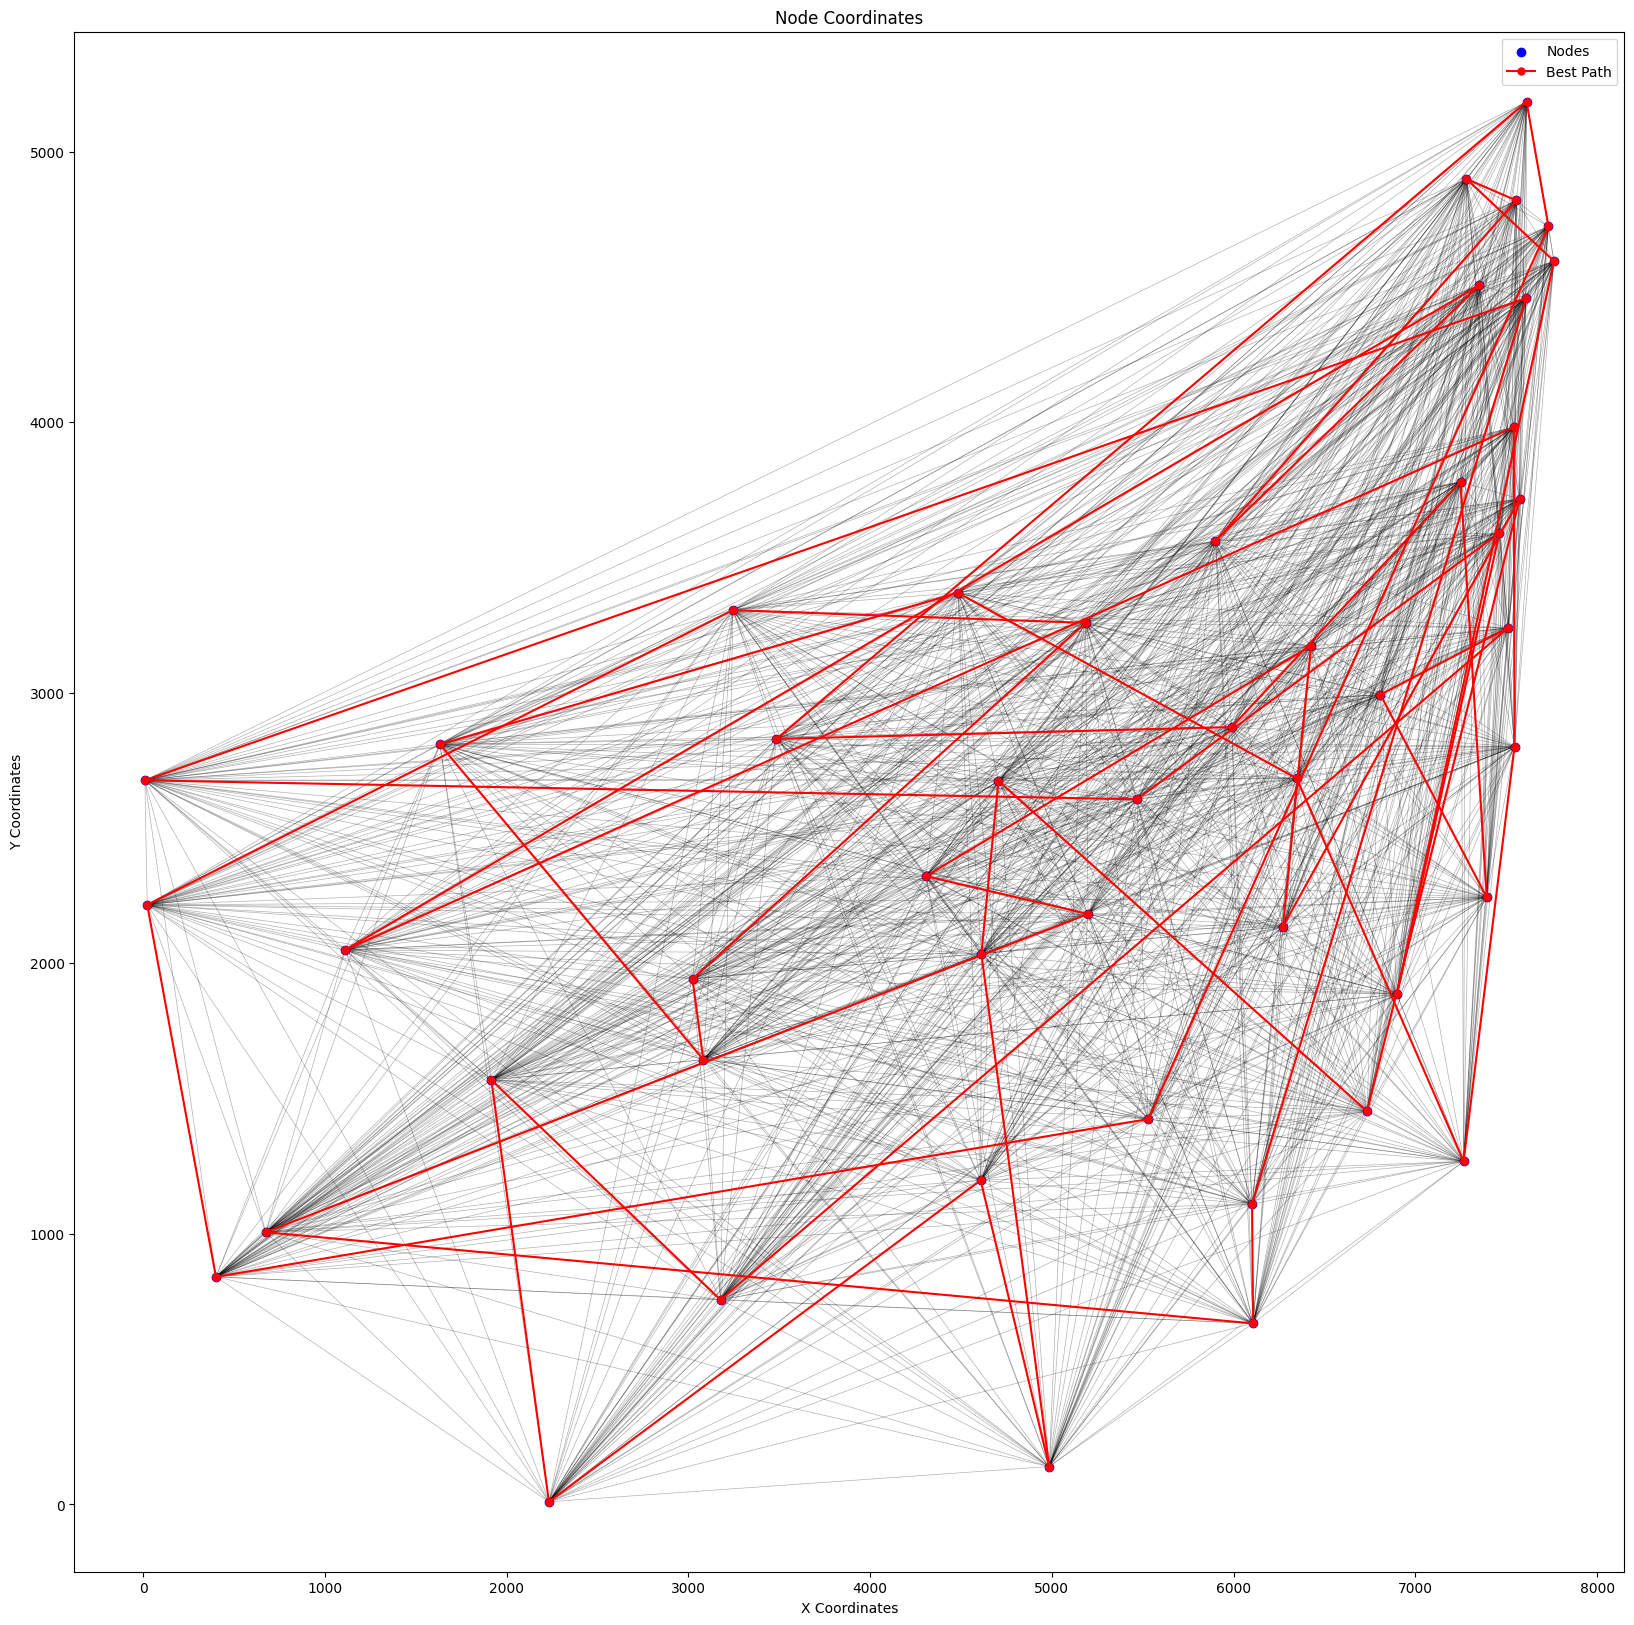

In [11]:
def plotBestPath(nodeCoordinates, distance_matrix, best_path):
    xCoords = [coord[0] for coord in nodeCoordinates.values()]
    yCoords = [coord[1] for coord in nodeCoordinates.values()]
    plt.figure(figsize=(20, 20))
    plt.scatter(xCoords, yCoords, c='blue', marker='o', label='Nodes')
    nodeCount = len(nodeCoordinates)
    for i in range(1, nodeCount + 1):
        for j in range(i + 1, nodeCount + 1): 
            if distance_matrix[i, j] > 0:
                x1, y1 = nodeCoordinates[i ]
                x2, y2 = nodeCoordinates[j]
                plt.plot([x1, x2], [y1, y2], 'k-', lw=0.5, alpha=0.3)
                
    xValues = []
    yValues = []
    bestPath = best_path.tolist()

    for i in bestPath:
        coords = nodeCoordinates[i]
        xValues.append(coords[0])
        yValues.append(coords[1])

    for i in range(len(xValues) - 1):
        plt.plot(xValues[i:i+2], yValues[i:i+2], 'ro-', markersize=5, label='Best Path' if i == 0 else "")
    plt.plot([xValues[-1], xValues[0]], [yValues[-1], yValues[0]], 'ro-', markersize=5)
    plt.xlabel('X Coordinates')
    plt.ylabel('Y Coordinates')
    plt.title('Node Coordinates')
    plt.legend()
    plt.show()


plotBestPath(att48.nodeCoordinates, distance_matrix, best_path)


Ideally the particles should prefer nodes that are closer ( have less edge weight). Also, currently only 1 swap happens per iteration, and the swap is random. Ideally, we should be able to intelligently make swaps, and possibly make sequences of swaps.  
prioritise nodes in neighbourhood  
maybe swap sections of the best path into the local path?

In [55]:
# def generateSwap(array1, array2):
#     array1 = torch.tensor(array1)
#     array2 = torch.tensor(array2)
#     idx = torch.randint(1, len(array2)-2, (1,)).item()
#     pair = [idx, idx+1]
#     return pair

class Particle:
   
    def __init__(self, nodeCount, swapCount=3, greedy=True):
        self.swapCount = swapCount
        self.nodeCount = nodeCount
        if greedy:
            self.initializeRouteKNN(distance_matrix=distance_matrix)
        else:
            self.position = torch.randperm(nodeCount) + 1
        self.fitnessValue = float("inf")
        self.localBestFitnessPosition = self.position.clone() 
        self.localBestFitnessValue = float("inf")
      
        self.velocity = [torch.randint(0, nodeCount, (2,)) for _ in range(swapCount)]
        #print(self.velocity)
        self.localBestVelocity = self.velocity
        self.bestCost = float("inf")
        
    #calculate length of current route. Goes through every element in position, and uses distance matrix to get edge length
    def calculateLength(self, distance_matrix):
        tour = self.position.tolist() 
        total_distance = sum(distance_matrix[tour[i], tour[i+1]] for i in range(len(tour)-1))
        total_distance += distance_matrix[tour[-1], tour[0]]
        self.fitnessValue = total_distance
        return total_distance
    
    def calculateRouteLength(self, position, distanceMatrix):
        tour = position.tolist() 
        total_distance = sum(distanceMatrix[tour[i], tour[i+1]] for i in range(len(tour)-1))
        total_distance += distanceMatrix[tour[-1], tour[0]]
        return total_distance
    
    def initializeRouteKNN(self, distance_matrix, k=5):
        nodeCount = distance_matrix.shape[0] - 1  # Adjust for zero-indexing
        startNode = torch.randint(1, nodeCount + 1, (1,)).item()  # Start from a random node (1-indexed)
        route = [startNode]  # Start with the chosen node
        unvisited = set(range(1, nodeCount + 1)) - {startNode}  # Remaining nodes

        currentNode = startNode
        while unvisited:
            distances = distance_matrix[currentNode, 1:]  
            nearestNeighbors = sorted([(distances[i], i + 1) for i in range(nodeCount) if (i + 1) in unvisited])[:k]
            nextNode = nearestNeighbors[torch.randint(0, len(nearestNeighbors), (1,)).item()][1]    
            route.append(nextNode)
            unvisited.remove(nextNode)
            currentNode = nextNode

        self.position = torch.tensor(route) 

    def updateVelocity(self, globalBestVelocity, distance_matrix, alpha=1, beta=1, gamma=1):
        randomMax = 1
        localBestMax = 1
        globalBestMax = 1
        max_attempts = 10  # Prevents infinite loop
        newVelocity = []

        count = 0
        # attempts = 0
        # while count < randomMax and attempts < max_attempts:
        #     swapOperation = torch.randint(0, self.nodeCount, (2,))
        #     i, j = swapOperation.tolist()
        #     newPosition = self.position.clone()  # Ensure a copy
        #     newPosition[i], newPosition[j] = newPosition[j].clone(), newPosition[i].clone()

        #     if self.calculateRouteLength(newPosition, distance_matrix) < self.calculateRouteLength(self.position, distance_matrix):
        #         newVelocity.append(swapOperation)
        #         count += 1
        #     attempts += 1  # Prevent infinite loop
        
        # Add swap from local best
        count = 0
        attempts = 0
        while count < localBestMax and attempts < max_attempts:
            swapOperation = self.localBestVelocity[torch.randint(0, self.swapCount-1, (1,)).item()]
            i, j = swapOperation.tolist()
            newPosition = self.position.clone()
            newPosition[i], newPosition[j] = newPosition[j].clone(), newPosition[i].clone()

            if self.calculateRouteLength(newPosition, distance_matrix) < self.calculateRouteLength(self.position, distance_matrix):
                newVelocity.append(swapOperation)
                count += 1
            attempts += 1
            if attempts > 3:
                newVelocity.append(swapOperation)
                count += 1
        # Add swap from global best
        count = 0
        attempts = 0
        while count < globalBestMax and attempts < max_attempts:
            swapOperation = globalBestVelocity[torch.randint(0, self.swapCount-1, (1,)).item()]
            i, j = swapOperation.tolist()
            newPosition = self.position.clone()
            newPosition[i], newPosition[j] = newPosition[j].clone(), newPosition[i].clone()

            if self.calculateRouteLength(newPosition, distance_matrix) < self.calculateRouteLength(self.position, distance_matrix):
                newVelocity.append(swapOperation)
                count += 1
            attempts += 1
            if attempts > 3:
                newVelocity.append(swapOperation)
                count += 1
        # If not enough good swaps, add random ones
        finalCount = 0
        while len(newVelocity) < self.swapCount:
            # if finalCount > 5000:
            #     break
            swapOperation = torch.randint(0, self.nodeCount, (2,))
            i, j = swapOperation.tolist()
            newPosition = self.position.clone()
            newPosition[i], newPosition[j] = newPosition[j].clone(), newPosition[i].clone()
            if self.calculateRouteLength(newPosition, distance_matrix) < self.calculateRouteLength(self.position, distance_matrix):
                newVelocity.append(swapOperation)
            finalCount += 1
                
            # while len(newVelocity) < self.swapCount:
            #     swapOperation = torch.randint(0, self.nodeCount, (2,))
            #     newVelocity.append(swapOperation)

        self.velocity = newVelocity
            

In [56]:
class ParticleSwarmOptimiser:
    def __init__(self, nodeCount, particleCount, inertia, particleCognition, socialInfluence, r1=1, r2=1, alpha=1, beta=1):
        self.particleSwarm = [Particle(nodeCount, swapCount=3) for _ in range(particleCount)]
        self.w = inertia
        self.c1 = particleCognition
        self.c2 = socialInfluence
        self.r1 = r1
        self.r2 = r2
        self.beta = beta
        self.alpha = alpha
        self.globalBestFitnessPosition = self.particleSwarm[0].position.clone()
        self.globalBestFitnessValue = float("inf")
        self.particleCount = particleCount
        self.globalBestVelocity = self.particleSwarm[0].velocity
    
    def getBestSolution(self):
        return self.globalBestFitnessPosition, self.globalBestFitnessValue

    def optimise(self, distance_matrix, maxIterations):
        for iteration in range(maxIterations):
            #print(self.globalBestVelocity)
            print(iteration)
            for particle in self.particleSwarm:
                fitness = particle.calculateLength(distance_matrix)
                #print(f"particles best path: {particle.localBestFitnessPosition}")
                #print(f"particles best value: {particle.localBestFitnessValue}")
                if fitness < particle.localBestFitnessValue:
                    particle.localBestFitnessValue = fitness
                    particle.localBestFitnessPosition = particle.position.clone()
                    particle.localBestVelocity = particle.velocity

                if fitness < self.globalBestFitnessValue:
                    self.globalBestFitnessValue = fitness
                    self.globalBestFitnessPosition = particle.position.clone()
                    self.globalBestVelocity = particle.localBestVelocity

            for particle in self.particleSwarm:
                new_position = self.swapMutation(particle.position.clone(), particle.velocity)
                particle.position = new_position
                particle.updateVelocity(self.globalBestVelocity, distance_matrix)
            print(f"particles best path: {self.globalBestFitnessPosition}")
            print(f"particles best value: {self.globalBestFitnessValue}")
            # if self.globalBestFitnessValue < 40000:
            #     break
                        
    def refine():
        #take in new hyperparameters without necessarily modifying particle swarm
        pass

    def swapMutation(self, position, velocity):  
        cutPoint = torch.randint(1, len(position)-1, (1,)).item()
        randomDecimal = torch.rand(1).item()
        # if randomDecimal > 0.5:
        #     segmentToAdd = self.globalBestFitnessPosition[:cutPoint].clone()
        #     positionRemainder = [x for x in position if x not in segmentToAdd]
        #     positionRemainder = [x for x in position if x not in segmentToAdd]
        #     position = torch.cat((segmentToAdd, torch.tensor(positionRemainder)))
        for [i, j] in velocity:
            position[i], position[j] = position[j].clone(), position[i].clone()
        return position
    
    


In [57]:
particleCount = 20
maxIterations = 100
inertia = 0.8
c1 = 1.5
c2 = 1.5

pso = ParticleSwarmOptimiser(
    nodeCount=att48.dimension,
    particleCount=particleCount,
    inertia=inertia,
    particleCognition=c1,
    socialInfluence=c2
)

pso.optimise(distance_matrix, maxIterations)
best_path, best_cost = pso.getBestSolution()

print("\nBest Path Found:", best_path.tolist())
print("Best Cost:", best_cost)
plotBestPath(att48.nodeCoordinates, distance_matrix, best_path)

0


KeyboardInterrupt: 

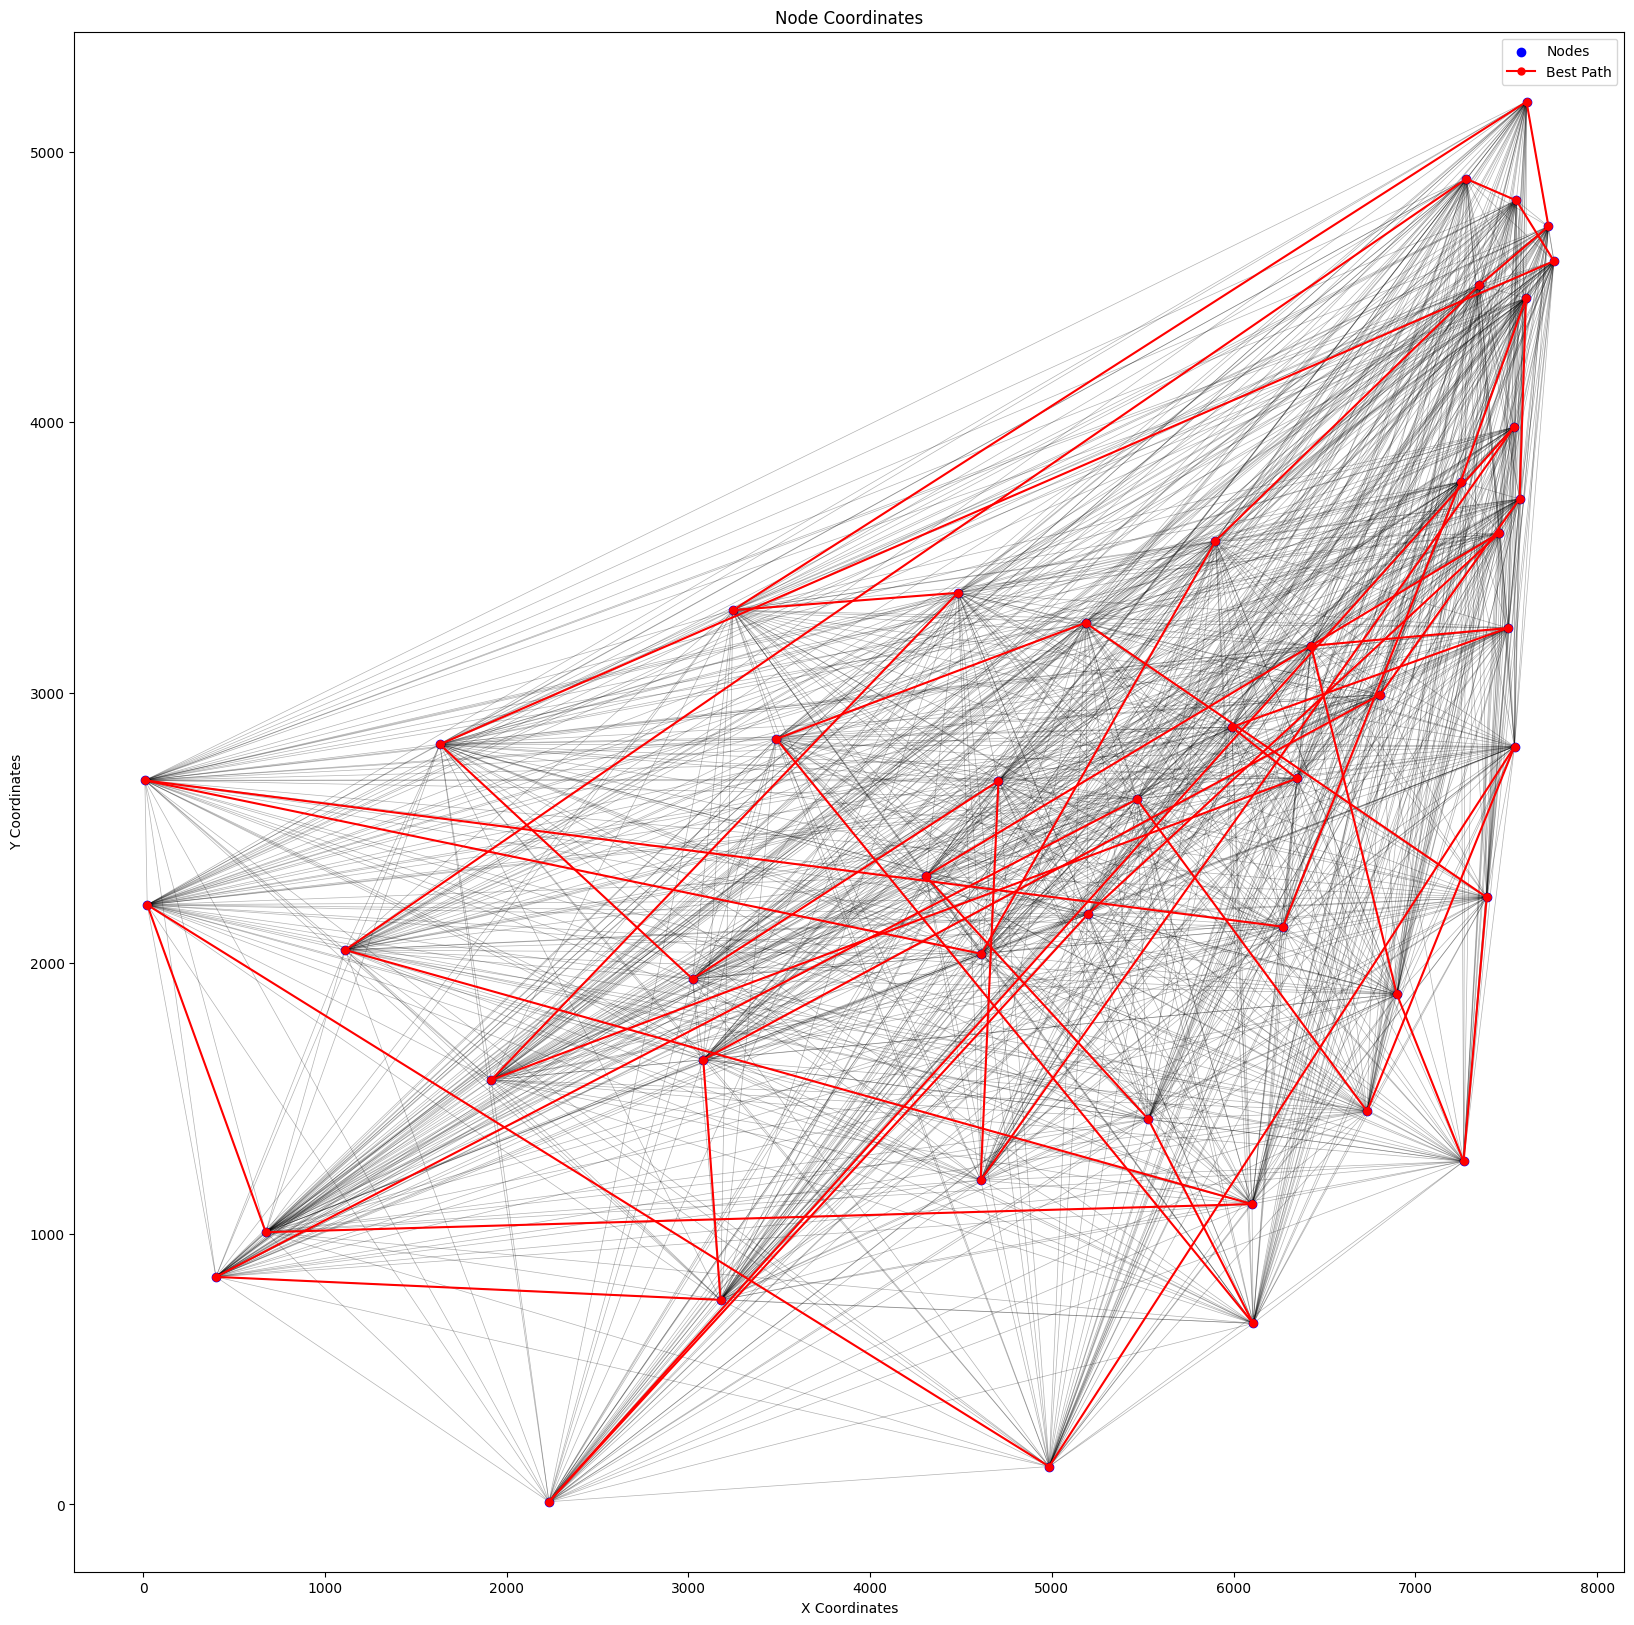

In [42]:
data = [37, 19, 27, 17, 43, 28, 30, 44, 31,  7, 18, 33, 23, 11, 12, 15, 46, 38,
         9,  8,  1, 40,  3, 22, 16, 41, 34,  5, 39, 25, 13, 47, 21, 32, 48, 24,
        42, 10, 45, 35,  4, 26,  2, 29, 14, 20, 36,  6]

tensor_data = torch.tensor(data)
plotBestPath(att48.nodeCoordinates, distance_matrix, best_path)